# [Template] K-Modes Machine Learning Clustering
* Last Update: Aug 1, 2018
* Author: taiconley@

#### Notes:
* This code analyzes DCM Data Transfer files to determine user level content pathing before a conversion. Then we send output at the user level with categories to an external environment to run K-Modes (https://pypi.org/project/kmodes/) 
* To use:
  * Update the project_id to one you have access to
  * Update query parameters for the client and campaigns you are analyzing
  * pip install kmodes

# Import libraries, Initialize BQ, and provide Parameters

In [0]:
from colabtools import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
#Initialize connetion to BQ
from colabtools import bigquery
bigquery.USE_LEGACY_SQL = False
project_id = "" #@param
bigquery.Create(project_id=project_id)

In [0]:
#Query Parameters
dataset_name = "" #@param
client_id = "" #@param
impression_table = "" #@param
activity_table =  #@param

campaign_IDs =  "('')" #@param
dbm_InsertionOrder_IDs = "()" #@param
activity_IDs = "('')" #@param

# potentionally other activity ids: 1529128, 2111421, 3139834, 3153417

timezone = "'America/New_York'" #@param
start_date = "''" #@param
end_date  = "''" #@param
time_lag_days = "30" #@param

#sample rate is the inverse of selection. ie, if 5 is picked, sample rate is 1 in 5
sample_rate = 10 #@param 

# Check Redaction

In [0]:
%%substitute_globals
%%bigquery Check

SELECT
Count (*) as Impressions,
SUM (Case when User_ID = '0' THEN 1 ELSE 0 END) AS User_ID0,
SUM (Active_View_Eligible_Impressions) AS Eligible_Impressions,
SUM (Active_View_Measurable_Impressions) AS Measurable_Impressions,
SUM (Active_View_Viewable_Impressions) AS Viewable_Impressions
FROM {impression_table}
WHERE Campaign_ID IN {campaign_IDs}
AND DBM_Insertion_Order_ID IN {dbm_InsertionOrder_IDs}
AND CAST(DATE(TIMESTAMP_MICROS(CAST(Event_Time as INT64)),"America/New_York") AS STRING) BETWEEN {start_date} AND {end_date}

Waiting on bqjob_red60fcc1783f228_00000164a3b79d16_2 ... (34s) Current status: DONE   


Saving results into 'Check'


In [0]:
Check['User_ID0_Percent'] = Check['User_ID0']/Check['Impressions']
Check

,Impressions,User_ID0,Eligible_Impressions,Measurable_Impressions,Viewable_Impressions,User_ID0_Percent
0,614842357,6544320,0,0,0,0.010644


# Explore URL Categories

In [0]:
%%substitute_globals
%%bigquery urlscat

SELECT
DBM_URL,
DBM_adx_Page_Categories,
Count (*) as Impressions
FROM {impression_table}
WHERE Campaign_ID IN {campaign_IDs}
#AND DBM_URL = 'https://www.factinate.com/interesting/40-little-known-facts-michael-jackson-3/22?fact=1'
AND DBM_Insertion_Order_ID IN {dbm_InsertionOrder_IDs}
AND User_ID != '0'
AND CAST(DATE(TIMESTAMP_MICROS(CAST(Event_Time as INT64)),"America/New_York") AS STRING) BETWEEN {start_date} AND {end_date}
GROUP BY 1,2
LIMIT 1000

Waiting on bqjob_r1165eefdd07b24e3_00000164a3b82cb3_3 ... (48s) Current status: DONE   


Saving results into 'urlscat'


In [0]:
urlscat.head()

,DBM_URL,DBM_adx_Page_Categories,Impressions
0,http://www.ebay.com/itm/183116763632,14 18 56 68 124 171 350 681,1
1,https://www.bestbuy.com/site/otterbox-defender...,13 382 390 1071 1171,1
2,https://www.bestbuy.com/site/searchpage.jsp?_d...,3 5 18 34 73 78 616,1
3,https://m.autotrader.com/cars-for-sale/vehicle...,47 815 826 5000 5237 5257 5287 5288 5428,1
4,https://m.accuweather.com/en/us/gouverneur-ny/...,16 63 5000 5237 5257 5277 5409 5411,1


# Main Queries to prep model and for data exploration

## User level output, which gets sent to K-Modes Model

In [0]:
%%substitute_globals
%%bigquery df
max_rows: 1500000

WITH 
conversions AS (  #Note - this includes unattributed conversions
  SELECT
    User_ID,
    MAX (Event_Time) AS Activity_Time # Capture the last site event for the user 
  FROM {activity_table}
  WHERE User_ID != "0"
    AND Activity_ID IN {activity_IDs}
    AND DATE(TIMESTAMP_MICROS(Event_Time),{timezone}) BETWEEN {start_date} AND {end_date}
    #AND User_ID = ''
  GROUP BY 1
),
 
impressions AS (
  SELECT
    User_ID,
    Event_Time AS Interaction_Time,
    DBM_URL,
    DBM_Adx_Page_Categories
    #DATETIME(TIMESTAMP_MICROS(Event_Time),{timezone}) AS Interaction_Time_Formatted
  FROM {impression_table}
  WHERE User_ID != "0"
    AND DBM_URL IS NOT NULL
    AND DBM_Adx_Page_Categories IS NOT NULL
    AND DATE(TIMESTAMP_MICROS(Event_Time),{timezone}) BETWEEN {start_date} AND {end_date}
),

full_path AS (
  SELECT *,
  (Activity_Time - Interaction_Time) as time_lag,
  (Activity_Time - Interaction_Time) * (1e6*60*60*24) as time_lag_days
  FROM impressions
  INNER JOIN conversions USING (User_ID)
  WHERE (Activity_Time - Interaction_Time) > 0
  AND (Activity_Time - Interaction_Time) < {time_lag_days}*(1e6*60*60*24)
),

all_categories AS (
SELECT 
User_ID,
CONCAT(",",REPLACE(REPLACE(STRING_AGG (DISTINCT DBM_ADX_Page_Categories), ","," ")," ",",")) as category
FROM full_path
GROUP BY 1
)

SELECT
User_ID,
category,
CASE WHEN category LIKE '%,3,%' THEN 1 ELSE 0 END AS Acting_Theater,
CASE WHEN category LIKE '%,47,%' THEN 1 ELSE 0 END AS Autos_Vehicles,
CASE WHEN category LIKE '%,44,%' THEN 1 ELSE 0 END AS Beauty_Fitness,
CASE WHEN category LIKE '%,22,%' THEN 1 ELSE 0 END AS Books_Literature,
CASE WHEN category LIKE '%,12,%' THEN 1 ELSE 0 END AS Business_Industrial,
CASE WHEN category LIKE '%,5,%' THEN 1 ELSE 0 END AS Computers_Electronics,
CASE WHEN category LIKE '%,7,%' THEN 1 ELSE 0 END AS Finance,
CASE WHEN category LIKE '%,8,%' THEN 1 ELSE 0 END AS Games,
CASE WHEN category LIKE '%,45,%' THEN 1 ELSE 0 END AS Health,
CASE WHEN category LIKE '%,65,%' THEN 1 ELSE 0 END AS Hobbies_Leisure,
CASE WHEN category LIKE '%,11,%' THEN 1 ELSE 0 END AS Home_Garden,
CASE WHEN category LIKE '%,13,%' THEN 1 ELSE 0 END AS Internet_Telecom,
CASE WHEN category LIKE '%,958,%' THEN 1 ELSE 0 END AS Jobs_Education,
CASE WHEN category LIKE '%,19,%' THEN 1 ELSE 0 END AS Law_Government,
CASE WHEN category LIKE '%,16,%' THEN 1 ELSE 0 END AS News,
CASE WHEN category LIKE '%,299,%' THEN 1 ELSE 0 END AS Online_Communities,
CASE WHEN category LIKE '%,14,%' THEN 1 ELSE 0 END AS People_Society,
CASE WHEN category LIKE '%,66,%' THEN 1 ELSE 0 END AS Pets_Animals,
CASE WHEN category LIKE '%,29,%' THEN 1 ELSE 0 END AS Real_Estate,
CASE WHEN category LIKE '%,533,%' THEN 1 ELSE 0 END AS Reference,
CASE WHEN category LIKE '%,174,%' THEN 1 ELSE 0 END AS Science,
CASE WHEN category LIKE '%,18,%' THEN 1 ELSE 0 END AS Shopping,
CASE WHEN category LIKE '%,20,%' THEN 1 ELSE 0 END AS Sports,
CASE WHEN category LIKE '%,67,%' THEN 1 ELSE 0 END AS Travel,
CASE WHEN category LIKE '%,5000,%' THEN 1 ELSE 0 END AS World_Localities
FROM
all_categories
#WHERE MOD(ABS(Farm_Fingerprint (User_ID)),{sample_rate})=0 #uncomment if you need to sample your data

Waiting on bqjob_r8e388731cb255e5_00000164ec6046ab_4 ... (48s) Current status: DONE   


Saving results into 'df'


## Paths output for all converters only (Used to calculate lift)

In [0]:
%%substitute_globals
%%bigquery df_allPaths_Converters
max_rows: 15000

# query provides an output with the count of cookies aggregated to the path level for converters only
WITH 
conversions AS (  #Note - this includes unattributed conversions
  SELECT
    User_ID,
    MAX (Event_Time) AS Activity_Time # Capture the last site event for the user 
  FROM {activity_table}
  WHERE User_ID != "0"
    AND Activity_ID IN {activity_IDs}
    AND DATE(TIMESTAMP_MICROS(Event_Time),{timezone}) BETWEEN {start_date} AND {end_date}
    
  GROUP BY 1
),
 
impressions AS (
  SELECT
    User_ID,
    Event_Time AS Interaction_Time,
    DBM_URL,
    DBM_Adx_Page_Categories
    #DATETIME(TIMESTAMP_MICROS(Event_Time),{timezone}) AS Interaction_Time_Formatted
  FROM {impression_table}
  WHERE User_ID != "0"
    AND DBM_URL IS NOT NULL
    AND DBM_Adx_Page_Categories IS NOT NULL
    AND DATE(TIMESTAMP_MICROS(Event_Time),{timezone}) BETWEEN {start_date} AND {end_date}
),

full_path AS (
  SELECT *,
  (Activity_Time - Interaction_Time) as time_lag,
  (Activity_Time - Interaction_Time) * (1e6*60*60*24) as time_lag_days
  FROM impressions
  INNER JOIN conversions USING (User_ID)
  WHERE (Activity_Time - Interaction_Time) > 0
  AND (Activity_Time - Interaction_Time) < {time_lag_days}*(1e6*60*60*24)
),

all_categories AS (
SELECT 
User_ID,
CONCAT(",",REPLACE(REPLACE(STRING_AGG (DISTINCT DBM_ADX_Page_Categories), ","," ")," ",",")) as category
FROM full_path
GROUP BY 1
),

all_categories_sampled AS (

SELECT
User_ID,
category,
CASE WHEN category LIKE '%,3,%' THEN 1 ELSE 0 END AS Acting_Theater,
CASE WHEN category LIKE '%,47,%' THEN 1 ELSE 0 END AS Autos_Vehicles,
CASE WHEN category LIKE '%,44,%' THEN 1 ELSE 0 END AS Beauty_Fitness,
CASE WHEN category LIKE '%,22,%' THEN 1 ELSE 0 END AS Books_Literature,
CASE WHEN category LIKE '%,12,%' THEN 1 ELSE 0 END AS Business_Industrial,
CASE WHEN category LIKE '%,5,%' THEN 1 ELSE 0 END AS Computers_Electronics,
CASE WHEN category LIKE '%,7,%' THEN 1 ELSE 0 END AS Finance,
CASE WHEN category LIKE '%,8,%' THEN 1 ELSE 0 END AS Games,
CASE WHEN category LIKE '%,45,%' THEN 1 ELSE 0 END AS Health,
CASE WHEN category LIKE '%,65,%' THEN 1 ELSE 0 END AS Hobbies_Leisure,
CASE WHEN category LIKE '%,11,%' THEN 1 ELSE 0 END AS Home_Garden,
CASE WHEN category LIKE '%,13,%' THEN 1 ELSE 0 END AS Internet_Telecom,
CASE WHEN category LIKE '%,958,%' THEN 1 ELSE 0 END AS Jobs_Education,
CASE WHEN category LIKE '%,19,%' THEN 1 ELSE 0 END AS Law_Government,
CASE WHEN category LIKE '%,16,%' THEN 1 ELSE 0 END AS News,
CASE WHEN category LIKE '%,299,%' THEN 1 ELSE 0 END AS Online_Communities,
CASE WHEN category LIKE '%,14,%' THEN 1 ELSE 0 END AS People_Society,
CASE WHEN category LIKE '%,66,%' THEN 1 ELSE 0 END AS Pets_Animals,
CASE WHEN category LIKE '%,29,%' THEN 1 ELSE 0 END AS Real_Estate,
CASE WHEN category LIKE '%,533,%' THEN 1 ELSE 0 END AS Reference,
CASE WHEN category LIKE '%,174,%' THEN 1 ELSE 0 END AS Science,
CASE WHEN category LIKE '%,18,%' THEN 1 ELSE 0 END AS Shopping,
CASE WHEN category LIKE '%,20,%' THEN 1 ELSE 0 END AS Sports,
CASE WHEN category LIKE '%,67,%' THEN 1 ELSE 0 END AS Travel,
CASE WHEN category LIKE '%,5000,%' THEN 1 ELSE 0 END AS World_Localities
FROM
all_categories
#WHERE MOD(ABS(Farm_Fingerprint (User_ID)),{sample_rate})=0 #uncomment to sample data
),

categories_string AS (
SELECT
User_ID,
category,
concat(
CAST (Acting_Theater AS string), "," ,
CAST (Autos_Vehicles AS string), "," ,
CAST (Beauty_Fitness AS string), "," ,
CAST (Books_Literature AS string), "," ,
CAST (Business_Industrial AS string), "," ,
CAST (Computers_Electronics AS string), "," ,
CAST (Finance AS string), "," ,
CAST (Games AS string), "," ,
CAST (Health AS string), "," ,
CAST (Hobbies_Leisure AS string), "," ,
CAST (Home_Garden AS string), "," ,
CAST (Internet_Telecom AS string), "," ,
CAST (Jobs_Education AS string), "," ,
CAST (Law_Government AS string), "," ,
CAST (News AS string), "," ,
CAST (Online_Communities AS string), "," ,
CAST (People_Society AS string), "," ,
CAST (Pets_Animals AS string), "," ,
CAST (Real_Estate AS string), "," ,
CAST (Reference AS string), "," ,
CAST (Science AS string), "," ,
CAST (Shopping AS string), "," ,
CAST (Sports AS string), "," ,
CAST (Travel AS string), "," ,
CAST (World_Localities AS string)) AS category_string
FROM all_categories_sampled
)

SELECT
category_string,
COUNT (User_ID) AS uniques
FROM
categories_string
GROUP BY 1
ORDER BY 2 DESC


Waiting on bqjob_r246e255e89a3038e_00000164cda31fd4_2 ... (34s) Current status: DONE   


Saving results into 'df_allPaths_Converters'


Truncated results at max_rows: 15000. See http://go/colab-bigquery-maxrows to increase.


In [0]:
df_allPaths_Converters.head()

,category_string,uniques
0,"0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0",6866
1,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0",3729
2,"0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1",2653
3,"1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0",2555
4,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0",2496


## Paths output for all converters only (Used to calculate lift)

In [0]:
%%substitute_globals
%%bigquery df_allPaths
max_rows: 15000

# query provides an output with the count of cookies aggregated to the path level
WITH 
 
impressions AS (
  SELECT
    User_ID,
    Event_Time AS Interaction_Time,
    DBM_URL,
    DBM_Adx_Page_Categories
  FROM {impression_table}
  WHERE User_ID != "0"
    AND DBM_URL IS NOT NULL
    AND DBM_Adx_Page_Categories IS NOT NULL
    AND DATE(TIMESTAMP_MICROS(Event_Time),{timezone}) BETWEEN {start_date} AND {end_date}
),

all_categories AS (
SELECT 
User_ID,
CONCAT(",",REPLACE(REPLACE(STRING_AGG (DISTINCT DBM_ADX_Page_Categories), ","," ")," ",",")) as category
FROM impressions
GROUP BY 1
),

all_categories_sampled AS (
SELECT
User_ID,
category,
CASE WHEN category LIKE '%,3,%' THEN 1 ELSE 0 END AS Acting_Theater,
CASE WHEN category LIKE '%,47,%' THEN 1 ELSE 0 END AS Autos_Vehicles,
CASE WHEN category LIKE '%,44,%' THEN 1 ELSE 0 END AS Beauty_Fitness,
CASE WHEN category LIKE '%,22,%' THEN 1 ELSE 0 END AS Books_Literature,
CASE WHEN category LIKE '%,12,%' THEN 1 ELSE 0 END AS Business_Industrial,
CASE WHEN category LIKE '%,5,%' THEN 1 ELSE 0 END AS Computers_Electronics,
CASE WHEN category LIKE '%,7,%' THEN 1 ELSE 0 END AS Finance,
CASE WHEN category LIKE '%,8,%' THEN 1 ELSE 0 END AS Games,
CASE WHEN category LIKE '%,45,%' THEN 1 ELSE 0 END AS Health,
CASE WHEN category LIKE '%,65,%' THEN 1 ELSE 0 END AS Hobbies_Leisure,
CASE WHEN category LIKE '%,11,%' THEN 1 ELSE 0 END AS Home_Garden,
CASE WHEN category LIKE '%,13,%' THEN 1 ELSE 0 END AS Internet_Telecom,
CASE WHEN category LIKE '%,958,%' THEN 1 ELSE 0 END AS Jobs_Education,
CASE WHEN category LIKE '%,19,%' THEN 1 ELSE 0 END AS Law_Government,
CASE WHEN category LIKE '%,16,%' THEN 1 ELSE 0 END AS News,
CASE WHEN category LIKE '%,299,%' THEN 1 ELSE 0 END AS Online_Communities,
CASE WHEN category LIKE '%,14,%' THEN 1 ELSE 0 END AS People_Society,
CASE WHEN category LIKE '%,66,%' THEN 1 ELSE 0 END AS Pets_Animals,
CASE WHEN category LIKE '%,29,%' THEN 1 ELSE 0 END AS Real_Estate,
CASE WHEN category LIKE '%,533,%' THEN 1 ELSE 0 END AS Reference,
CASE WHEN category LIKE '%,174,%' THEN 1 ELSE 0 END AS Science,
CASE WHEN category LIKE '%,18,%' THEN 1 ELSE 0 END AS Shopping,
CASE WHEN category LIKE '%,20,%' THEN 1 ELSE 0 END AS Sports,
CASE WHEN category LIKE '%,67,%' THEN 1 ELSE 0 END AS Travel,
CASE WHEN category LIKE '%,5000,%' THEN 1 ELSE 0 END AS World_Localities
FROM
all_categories
#WHERE MOD(ABS(Farm_Fingerprint (User_ID)),{sample_rate})=0 #uncomment to sample data
),

categories_string AS (
SELECT
User_ID,
category,
concat(
CAST (Acting_Theater AS string), "," ,
CAST (Autos_Vehicles AS string), "," ,
CAST (Beauty_Fitness AS string), "," ,
CAST (Books_Literature AS string), "," ,
CAST (Business_Industrial AS string), "," ,
CAST (Computers_Electronics AS string), "," ,
CAST (Finance AS string), "," ,
CAST (Games AS string), "," ,
CAST (Health AS string), "," ,
CAST (Hobbies_Leisure AS string), "," ,
CAST (Home_Garden AS string), "," ,
CAST (Internet_Telecom AS string), "," ,
CAST (Jobs_Education AS string), "," ,
CAST (Law_Government AS string), "," ,
CAST (News AS string), "," ,
CAST (Online_Communities AS string), "," ,
CAST (People_Society AS string), "," ,
CAST (Pets_Animals AS string), "," ,
CAST (Real_Estate AS string), "," ,
CAST (Reference AS string), "," ,
CAST (Science AS string), "," ,
CAST (Shopping AS string), "," ,
CAST (Sports AS string), "," ,
CAST (Travel AS string), "," ,
CAST (World_Localities AS string)) AS category_string
FROM all_categories_sampled
)

SELECT
category_string,
COUNT (User_ID) AS uniques
FROM
categories_string
GROUP BY 1
ORDER BY 2 DESC

Waiting on bqjob_r428ea6cad304462b_00000164cda3afce_3 ... (86s) Current status: DONE   


Saving results into 'df_allPaths'


Truncated results at max_rows: 15000. See http://go/colab-bigquery-maxrows to increase.


In [0]:
df_allPaths.head()

,category_string,uniques
0,"1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0",27889796
1,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0",21234130
2,"0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0",16589590
3,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0",15579078
4,"1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0",14243281


In [0]:
df.drop(['category'], axis=1).head()

,User_ID,Acting_Theater,Autos_Vehicles,Beauty_Fitness,Books_Literature,Business_Industrial,Computers_Electronics,Finance,Games,Health,...,Online_Communities,People_Society,Pets_Animals,Real_Estate,Reference,Science,Shopping,Sports,Travel,World_Localities
0,CAESECWvI7DZYOWD8S69Nm7o4sU,0,0,0,0,1,0,1,0,1,...,0,0,0,0,1,1,1,0,0,0
1,CAESEEMUusIAjlacxDvd9wbhpvM,1,0,0,1,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
2,CAESEOMo4mm7x30CdSHJSK0dddw,1,0,1,0,1,0,0,0,1,...,1,1,0,0,1,1,0,0,0,0
3,CAESEAhtY4Xsxia4ez4oDkZ6lIc,1,0,1,1,0,0,0,0,1,...,1,1,0,0,1,0,1,0,0,0
4,CAESENEJoX1W7G5gAewKFFoq8zU,1,1,0,0,0,0,1,0,1,...,0,1,1,0,1,0,0,0,0,0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119421 entries, 0 to 119420
Data columns (total 27 columns):
User_ID                  119421 non-null object
category                 119421 non-null object
Acting_Theater           119421 non-null int64
Autos_Vehicles           119421 non-null int64
Beauty_Fitness           119421 non-null int64
Books_Literature         119421 non-null int64
Business_Industrial      119421 non-null int64
Computers_Electronics    119421 non-null int64
Finance                  119421 non-null int64
Games                    119421 non-null int64
Health                   119421 non-null int64
Hobbies_Leisure          119421 non-null int64
Home_Garden              119421 non-null int64
Internet_Telecom         119421 non-null int64
Jobs_Education           119421 non-null int64
Law_Government           119421 non-null int64
News                     119421 non-null int64
Online_Communities       119421 non-null int64
People_Society           119421 non-null 

# Model

In [0]:
df2 = df.drop(['User_ID', 'category'], axis=1)

In [0]:
df2.head()

,Acting_Theater,Autos_Vehicles,Beauty_Fitness,Books_Literature,Business_Industrial,Computers_Electronics,Finance,Games,Health,Hobbies_Leisure,...,Online_Communities,People_Society,Pets_Animals,Real_Estate,Reference,Science,Shopping,Sports,Travel,World_Localities
0,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,1,1,1,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
2,1,0,1,0,1,0,0,0,1,0,...,1,1,0,0,1,1,0,0,0,0
3,1,0,1,1,0,0,0,0,1,0,...,1,1,0,0,1,0,1,0,0,0
4,1,1,0,0,0,0,1,0,1,0,...,0,1,1,0,1,0,0,0,0,0


## Send df external to run kModes outside of colab

In [0]:
#send df2 to path for model to run
df2.to_csv(path_or_buf='data.csv',index=False,header=False)

## Bring model output back to colab, then send results to Google Sheets

In [0]:
# Bring output of model back to colab
file = %upload_files
file = file.get('output.csv')
file2 = file
file2 = file2[3:-5]
file2 = file2.replace('.', ',')
file2 = file2.replace('\n','')
file2 = file2.replace(' ','')

#my_list gets the model output
my_list = file2.split(',][') 

#lst gets the header names
lst = []
lst = list(df2)
lst = [item.encode('utf-8') for item in lst]

#df3 is the df of the model output
df3 = pd.DataFrame([sub.split(",") for sub in my_list])
df3 = df3.drop(df3.columns[len(df3.columns)-1], axis=1)
df3.columns = lst

In [0]:
df3

,Acting_Theater,Autos_Vehicles,Beauty_Fitness,Books_Literature,Business_Industrial,Computers_Electronics,Finance,Games,Health,Hobbies_Leisure,...,Online_Communities,People_Society,Pets_Animals,Real_Estate,Reference,Science,Shopping,Sports,Travel,World_Localities
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
5,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
# Use to build a new
from colabtools import sheets
sheet_id = sheets.create_spreadsheet('kModes'+str({dataset_name})) #build new workbook
# Add New Sheets below
kmodes = sheets.add_worksheet(sheet_id, 'kModes')
converterPaths = sheets.add_worksheet(sheet_id, 'converterPaths')
allPaths = sheets.add_worksheet(sheet_id, 'allPaths')

Beginning OAuth2 authorization process ...
Loaded cached OAuth2 token.


In [0]:
%%substitute_globals
%%html
<a target="_blank" href="https://docs.google.com/spreadsheets/d/{sheet_id}/edit">
Use this sheet!
</a>

In [0]:
# if sheet is expired
# sheed_id = ''

In [0]:
sheets.update_cells(sheet_id, kmodes, df3 ,1,1,True, True) #the output model
sheets.update_cells(sheet_id, converterPaths, df_allPaths_Converters ,1,1,True, True) #raw data for only converting paths
sheets.update_cells(sheet_id, allPaths , df_allPaths ,1,1,True, True) #raw data for all paths

337 cells updated.


# Data Exploration

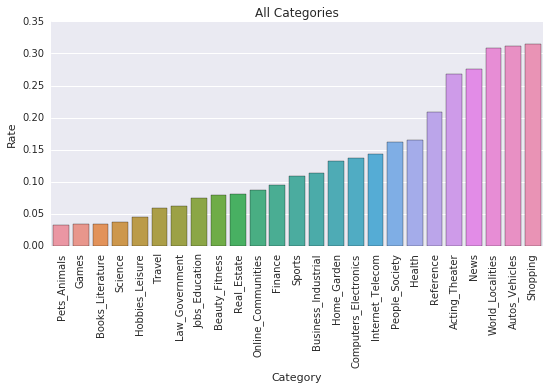

In [0]:
col_list= list(df)
col_list.remove('User_ID')
col_list.remove('category')

summary = df[col_list].sum().sort_values(ascending = False)
summary2 = df[col_list].count().sort_values(ascending = False)

dfexp = pd.concat([summary, summary2], axis=1)
dfexp = dfexp.reset_index()
dfexp = dfexp.rename(index=str, columns={"index": "Category", 0: "Sum", 1: "Count"})
dfexp = dfexp.sort_values('Sum')
dfexp['Rate']=dfexp['Sum']/dfexp['Count']

g = sns.factorplot(x="Category",y='Rate', kind='bar',aspect=2, data=dfexp)
g.set_xticklabels(rotation=90)
g.ax.set_title("All Categories")

In [0]:
n = 4 #user input
lst_summary = list(summary.index)[0:n]

In [0]:
#custom function
def process (sub_category):
  mask = df[sub_category] == 1
  df_category = df[mask]
  mask = 0
  summary_category = df_category[col_list].sum().sort_values()
  summary2_category = df_category[col_list].count().sort_values()
  df2_category = pd.concat([summary_category, summary2_category], axis=1)
  df2_category = df2_category.reset_index()
  df2_category = df2_category.rename(index=str, columns={"index": "Category", 0: "Sum", 1: "Count"})
  df2_category = df2_category.sort_values('Sum')
  df2_category['Rate']=df2_category['Sum']/df2_category['Count']
  mask2=df2_category['Category'] != sub_category
  df2_category = df2_category[mask2]
  mask2 = 0
  g_category = sns.factorplot(x="Category",y='Rate', kind='bar',aspect=2, data=df2_category, margin_titles=True)
  g_category.set_xticklabels(rotation=90)
  g_category.ax.set_title("Category: "+str(sub_category))

Shopping
Autos_Vehicles
World_Localities
News


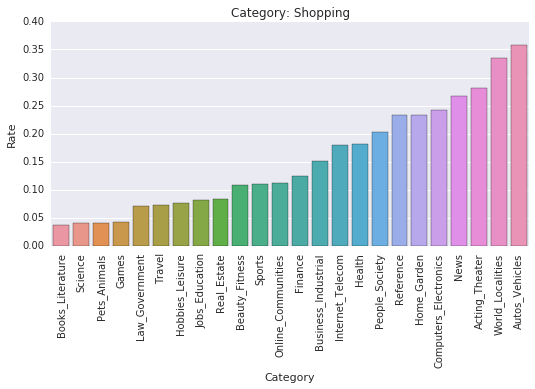

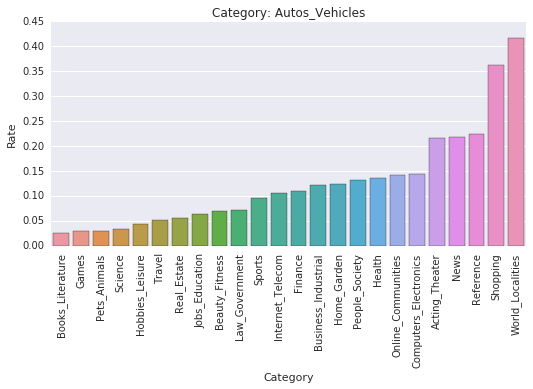

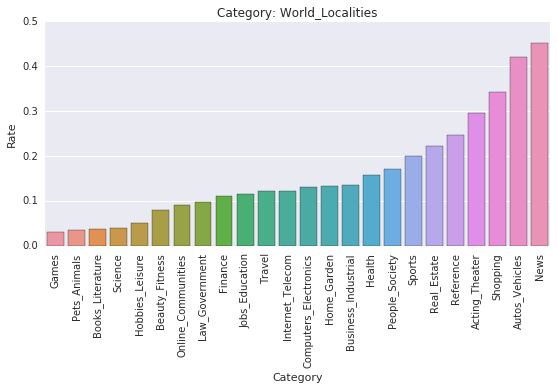

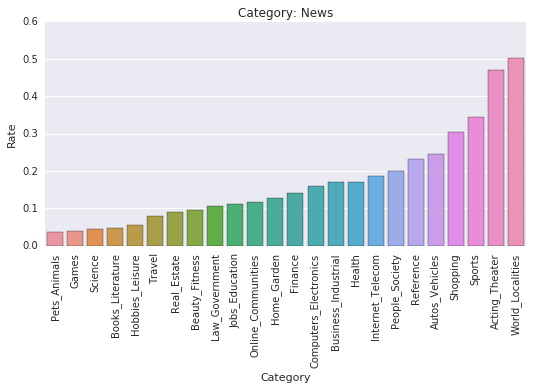

In [0]:
for x in lst_summary:
  print x
  process(x)